# Clustering

## 1. Distance-based Clustering
### Centroid-based Clustering K-Means

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

### Create Sample Data

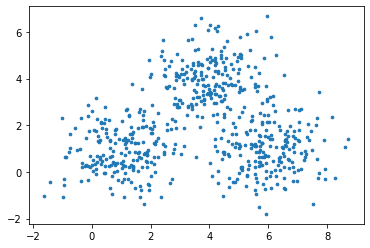

In [2]:
# Set three centers, the model should predict similar results
center_1 = np.array([1,1])
center_2 = np.array([4,4])
center_3 = np.array([6,1])

# Generate random data and center it to the three centers
data_1 = np.random.randn(200,2) + center_1
data_2 = np.random.randn(200,2) + center_2
data_3 = np.random.randn(200,2) + center_3

data = np.concatenate((data_1, data_2, data_3), axis = 0)

plt.scatter(data[:,0], data[:,1], s=7)

### Config & Random Center

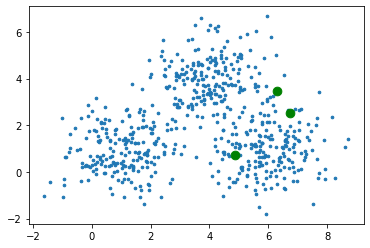

In [3]:
# Plot the data and the centers generated as random
plt.scatter(data[:,0], data[:,1], s=7)
plt.scatter(centers[:,0], centers[:,1], marker='.', c='g', s=300)

### K-MEAN Algorithm

In [108]:
def KMeanClustering(data, k=3, distance_metric = 'euclidean', minkowski_p = 3):
    assert distance_metric in ['euclidean', 'manhattan', 'minkowski'], \
        "Available distance metrics are: euclidean, manhattan, minkowski"
    # Number of training data
    n = data.shape[0]
    # Number of features in the data
    c = data.shape[1]

    # Generate random centers, here we use sigma and mean to ensure it represent the whole data
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    centers = np.random.randn(k,c)*std + mean

    centers_old = np.zeros(centers.shape) # to store old centers
    centers_new = deepcopy(centers) # Store new centers
    clusters = np.zeros(n)
    distances = np.zeros((n,k))
    if distance_metric == 'euclidean':
        error = np.linalg.norm(centers_new - centers_old)
    elif distance_metric == 'manhattan':
        error = np.sum(np.fabs(centers_new - centers_old))
    else:
        print('Default minkowski_p = {}'.format(minkowski_p))
        error = np.sum(np.power(np.fabs(centers_new - centers_old), minkowski_p))**1/minkowski_p
    # When, after an update, the estimate of that center stays the same, exit loop
    errors = []
    while error != 0:
        # Measure the distance to every center
        for i in range(k):
            if distance_metric == 'euclidean':
                distances[:,i] = np.linalg.norm(data - centers[i], axis=1)
            elif distance_metric == 'manhattan':
                distances[:,i] = np.sum(np.fabs(data - centers[i]), axis=1)
            else:
                distances[:,i] = np.sum(np.power(np.fabs(data - centers[i]), minkowski_p), axis = 1)**1/minkowski_p
            #distances[:,i] = np.linalg.norm(data - centers[i], axis=1)
        # Assign all training data to closest center
        clusters = np.argmin(distances, axis = 1)
        # Calculate mean for every cluster and update the center
        for i in range(k):
            centers_new[i] = np.mean(data[clusters == i], axis=0)
        error = np.linalg.norm(centers_new - centers)
        errors.append(error)
        centers = deepcopy(centers_new)
    return centers_new, clusters, errors    

In [109]:
def visualize(data, centers_new, clusters, k = 3):
    colors = ['r', 'g', 'b']
    for i in range(k):
        current_cluster = np.squeeze(np.argwhere(clusters==i))
        tmp = data[current_cluster]
        plt.scatter(tmp[:, 0], tmp[:, 1], c = colors[i], s = 10)
    plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)
    plt.show()

In [7]:
def draw_char(errors):
    X_bar = np.arange(len(errors))
    plt.plot(X_bar, errors, 'r')
    plt.show()

##### Test with different metrics: Euclidean, Manhattan, Minkowski

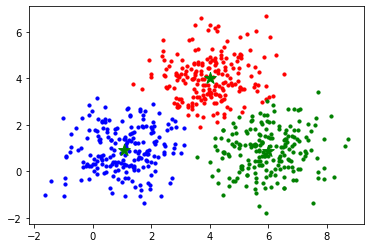

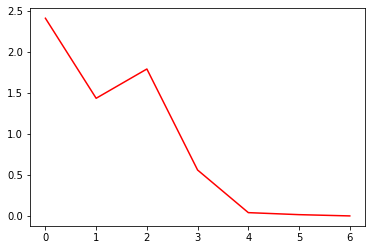

In [53]:
# Using Euclidean metric
centers_new, clusters, errors = KMeanClustering(data, distance_metric = 'euclidean')
visualize(data, centers_new, clusters)
draw_char(errors)

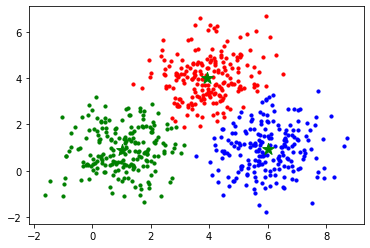

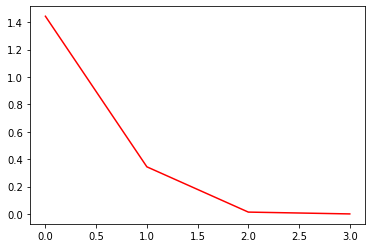

In [54]:
# Using Manhattan metric
centers_new, clusters, errors = KMeanClustering(data, distance_metric = 'manhattan')
visualize(data, centers_new, clusters)
draw_char(errors)

Default minkowski_p = 3


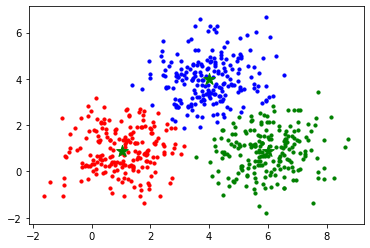

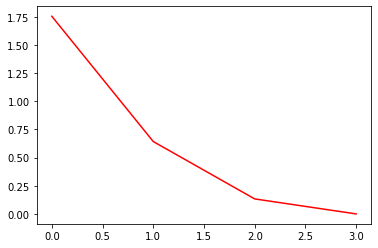

In [57]:
# Using Minkowski metric
centers_new, clusters, errors = KMeanClustering(data, distance_metric = 'minkowski')
visualize(data, centers_new, clusters)
draw_char(errors)

#### Test with MNIST Dataset

In [36]:
def visualize_mnist(X0, centers, clusters, errors, N0=30):
    k = len(centers)
    X1 = np.zeros((N0*k, 784))
    for i in range(k):
        Xk = X0[clusters == i]
        X1[N0*i: N0*i+N0, :] = Xk[:N0, :]
    plt.axis('off')
    A = display_network(X1.T, k, N0)
    plt.figure(figsize = (20,10))
    plt.imshow(A, interpolation='nearest')
    plt.gray()
    plt.show()

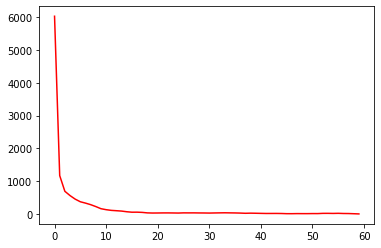

In [14]:
from mnist import MNIST
from display_network import *

mndata = MNIST('./MNIST/') # path to your MNIST folder 
mndata.load_testing()
X = mndata.test_images
X = np.array(X)
centers_new, clusters, errors = KMeanClustering(X, k=10, distance_metric = 'euclidean')
draw_char(errors)

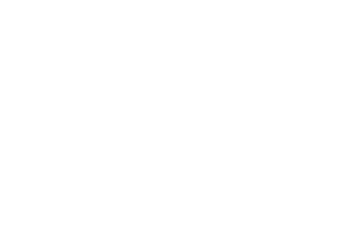

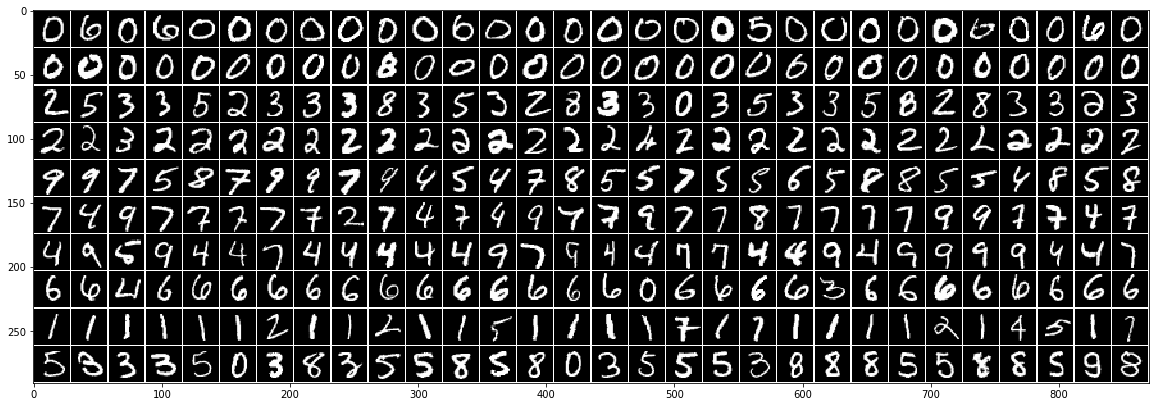

In [37]:
visualize_mnist(X, centers_new, clusters, errors)

## 2. Hierarchical Clustering

### Agglomerative Hierarchical Clustering

In [46]:
# Main algorithm    
def compute_distance_matrix(samples):
    '''
        Compute distance matrix one-by-one
    '''
    dist = np.zeros((len(samples),len(samples)))
    for i in range(dist.shape[0]):
        for j in range(dist.shape[0]):
            if i <= j:
                if i != j:
                    dist[i, j] = float(calculate_distance(np.array(samples[i]), np.array(samples[j])))
                    dist[j, i] = dist[i, j]
                else:
                    dist[i,j] = 10**6
    return dist

def calculate_distance(numpy_A, numpy_B):
    '''
        Compute distance between 2 numpy array
            M x 768       N x 768
        Using more resource for faster computation
        return
            min of (M x N) distance matrix 
    '''
    A = numpy_A.copy()
    B = numpy_B.copy()
    number_boxes_A = len(A)
    number_boxes_B = len(B)
    AA = np.repeat(A, number_boxes_B, 0)
    BB = np.tile(B, (number_boxes_A, 1))
    return np.amin(np.linalg.norm(AA - BB, axis = 1))
    
# def calculate_distance(sample1, sample2):
#    '''
#        Calculate distance between 2 sample (can be sample or cluster)
#    '''
#    dist = []
#    for i in range(len(sample1)):
#        for j in range(len(sample2)):
#            try:
#                dist.append(np.linalg.norm(np.array(sample1[i])-np.array(sample2[j])))
#            except:
#                dist.append(inter_sample_distance(sample1[i], sample2[j]))
#    return min(dist)

# def inter_cluster_distance(cl, sample):
#    '''
#        Compute distance between sample in cluster and actual sample
#    '''
#    if type(sample[0]).__name__ != 'list':
#        sample = [sample]
#    dist   = []
#    for i in range(len(cl)):
#        for j in range(len(sample)):
#            dist.append(np.linalg.norm(np.array(cl[i])-np.array(sample[j])))
#    return min(dist)
#    
# def inter_sample_distance(s1, s2):
#    '''
#        Main compute distance between cluster and sample
#    '''
#    if type(s2[0]).__name__ !='list':
#        s2=[s2]
#    if type(s1[0]).__name__ !='list':
#        s1=[s1]
#    m = len(s1)
#    n = len(s2)
#    dist = []
#    if n>=m:
#        for i in range(n):
#            for j in range(m):
#                if (len(s2[i])>=len(s1[j])) and str(type(s2[i][0]).__name__ != 'list'):
#                    dist.append(inter_cluster_distance(s2[i],s1[j]))
#                else:
#                    dist.append(np.linalg.norm(np.array(s2[i])-np.array(s1[j])))
#    else:
#        for i in range(m):
#            for j in range(n):
#                if (len(s1[i])>=len(s2[j])) and str(type(s1[i][0]).__name__ != 'list'):
#                    dist.append(inter_cluster_distance(s1[i],s2[j]))
#                else:
#                    dist.append(np.linalg.norm(np.array(s1[i])-np.array(s2[j])))
#    return min(dist)    

In [47]:
class HierarchicalClustering:
    def __init__(self):
        pass
    
    def fit(self, X, show = True):
        self.clusters = dict()
        samples     = [[list(X[i])] for i in range(X.shape[0])]
        m = len(samples)
        self.clusters[m] = [[i] for i in range(X.shape[0])]
        while m > 1:
            dist      = compute_distance_matrix(samples)
            sample_ind_needed = np.where(dist==dist.min())[0]
            value_to_add      = samples.pop(sample_ind_needed[1])
            samples[sample_ind_needed[0]].append(value_to_add[0])
            if show:
                print('-> Merge {} with {}'.format(self.clusters[m][sample_ind_needed[0]], \
                                                   self.clusters[m][sample_ind_needed[1]]))
            m = len(samples)
            self.clusters[m] = deepcopy(self.clusters[m+1])
            self.clusters[m][sample_ind_needed[0]] += self.clusters[m][sample_ind_needed[1]]
            v = self.clusters[m].pop(sample_ind_needed[1])
            if show:
                print('-> Current cluster      :-',self.clusters[m])
                print('====================================================================================================')
    def get_predict_k(self, k):
        return self.clusters[k]

In [48]:
X = np.array([[1.4, 5.7],
              [5.5, 9.4],
              [6.4, 7.5],
              [2.4, 9.0],
              [10.0, 10.0],
              [9.4, 2.4],
              [6.83, 8.9]])
model = HierarchicalClustering()
model.fit(X)

-> Merge [1] with [6]
-> Current cluster      :- [[0], [1, 6], [2], [3], [4], [5]]
-> Merge [1, 6] with [2]
-> Current cluster      :- [[0], [1, 6, 2], [3], [4], [5]]
-> Merge [1, 6, 2] with [3]
-> Current cluster      :- [[0], [1, 6, 2, 3], [4], [5]]
-> Merge [1, 6, 2, 3] with [4]
-> Current cluster      :- [[0], [1, 6, 2, 3, 4], [5]]
-> Merge [0] with [1, 6, 2, 3, 4]
-> Current cluster      :- [[0, 1, 6, 2, 3, 4], [5]]
-> Merge [0, 1, 6, 2, 3, 4] with [5]
-> Current cluster      :- [[0, 1, 6, 2, 3, 4, 5]]


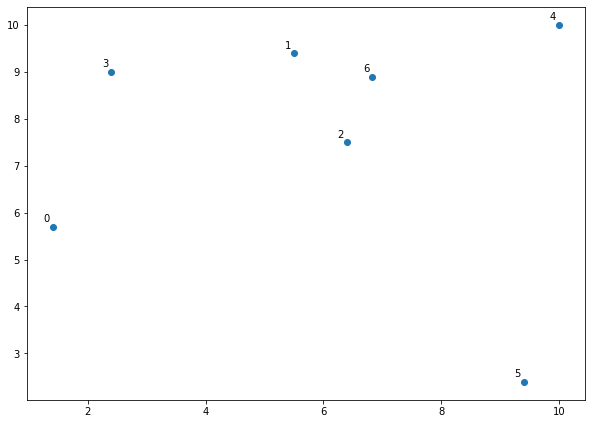

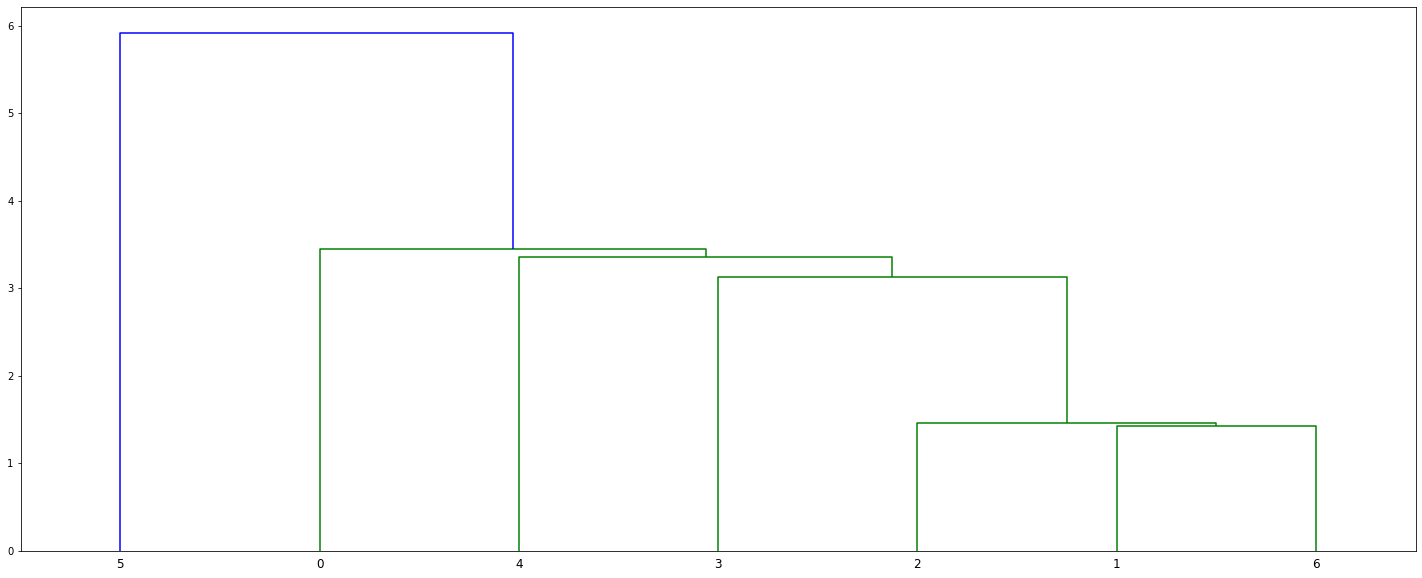

In [6]:
# Visualize
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
labels = range(len(X))
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(X[:,0],X[:,1], label='True Position')

for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

Z = linkage(X, 'single')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

#### Hierarchical Clustering MNIST

In [62]:
from mnist import MNIST
from display_network import *
def visualize_hier_cluster(X0, clusters, N0 = 5):
    k = len(clusters)
    X1 = np.zeros((N0*k, 784))
    for i in range(k):
        Xk = X0[clusters[i]]
        if len(Xk) > N0:
            X1[N0*i: N0*i+N0, :] = Xk[:N0, :]
        else:
            X1[N0*i: N0*i+len(Xk), :] = Xk
    plt.axis('off')
    A = display_network(X1.T, k, N0)
    plt.figure(figsize = (20,10))
    plt.imshow(A, interpolation='nearest')
    plt.gray()
    plt.show()

In [58]:
from copy import deepcopy
from sklearn.utils import shuffle
mndata = MNIST('./MNIST/') # path to your MNIST folder 
mndata.load_testing()
X = mndata.test_images
X = np.array(X)
# Get subset of data
X = shuffle(X, random_state = 1234)
X = X[:100]
model2 = HierarchicalClustering()
model2.fit(X, show = False)

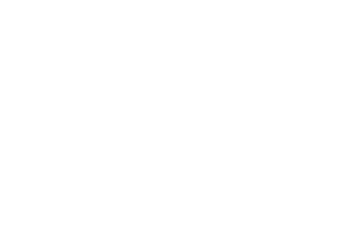

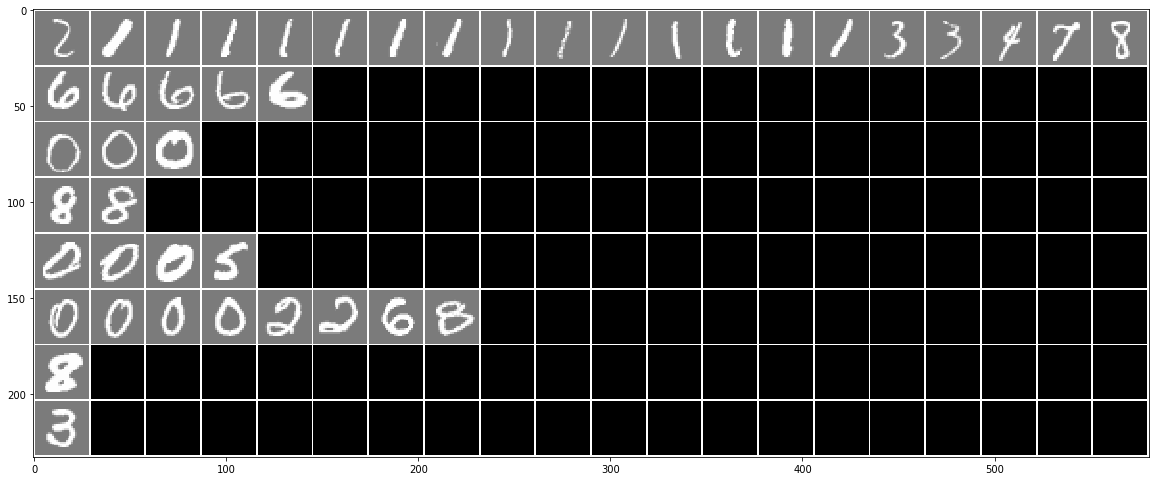

In [66]:
# Visualize with 8 clusters
clusters = model2.clusters[8]
visualize_hier_cluster(X.astype('uint8'), clusters, N0 = 20)

## 3. Density-based  Clustering

### DBSCAN Algorithm

In [67]:
# Import library
import queue
import collections

In [68]:
# Assign label for differnt point group
NOISE = 0
UNASSIGNED = 0
CORE = -1
EDGE = -2

In [69]:
# Find all neigbor points in radius
def neighbor_points(data, pointId, radius):
    points = []
    for i in range(len(data)):
        # Euclidean distance
        if np.linalg.norm(data[i] - data[pointId]) <= radius:
            points.append(i)
    return points

In [70]:
# DBSCAN Algorithm
def dbscan(data, Eps, MinPt):
    # initialize all points to unassign
    pointlabel  = [UNASSIGNED] * len(data)
    pointcount = []
    # initialize list for CORE/NON-CORE points
    corepoint = []
    noncore = []
    
    # Find all neighbor for all points
    for i in range(len(data)):
        pointcount.append(neighbor_points(train,i,Eps))
    
    # Find all CORE points, EDGE point and NOISE
    for i in range(len(pointcount)):
        if (len(pointcount[i]) >= MinPt):
            pointlabel[i] = CORE
            corepoint.append(i)
        else:
            noncore.append(i)
    for i in noncore:
        for j in pointcount[i]:
            if j in corepoint:
                pointlabel[i]=EDGE
                break
            
    # start assigning point to cluster
    cl = 1
    # Using a Queue to put all neighbor CORE-point in queue and find neighbor's neighbor
    for i in range(len(pointlabel)):
        q = queue.Queue()
        if (pointlabel[i] == CORE):
            pointlabel[i] = cl
            for x in pointcount[i]:
                if(pointlabel[x] == CORE):
                    q.put(x)
                    pointlabel[x] = cl
                elif(pointlabel[x] == EDGE):
                    pointlabel[x] = cl
            # Stop when all point in Queue has been checked   
            while not q.empty():
                neighbors = pointcount[q.get()]
                for y in neighbors:
                    if (pointlabel[y] == CORE):
                        pointlabel[y] = cl
                        q.put(y)
                    if (pointlabel[y] == EDGE):
                        pointlabel[y] = cl            
            cl += 1 # move to next cluster
           
    return pointlabel, cl

In [71]:
# Function to plot final result
def plotRes(data, clusterRes, clusterNum):
    nPoints = len(data)
    scatterColors = ['black', 'green', 'brown', 'red', 'purple', 'orange', 'yellow']
    for i in range(clusterNum):
        if (i==0):
            # Plot all noise point as black
            color = 'black'
        else:
            color = scatterColors[i % len(scatterColors)]
        x1 = [];  y1 = []
        for j in range(nPoints):
            if clusterRes[j] == i:
                x1.append(data[j, 0])
                y1.append(data[j, 1])
        plt.scatter(x1, y1, c=color, alpha=1, marker='.')

EPS = 0.4, Min-points = 10
Number of cluster: 6
Number of outliers: 204


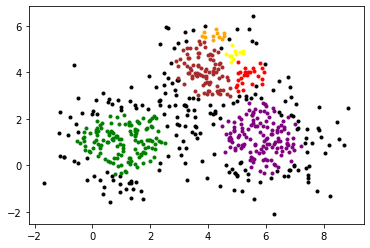

EPS = 0.4, Min-points = 15
Number of cluster: 7
Number of outliers: 398


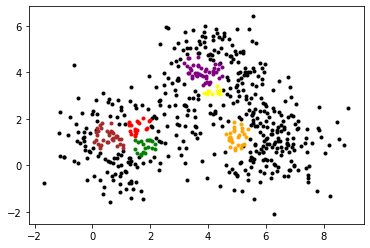

EPS = 0.6, Min-points = 10
Number of cluster: 1
Number of outliers: 41


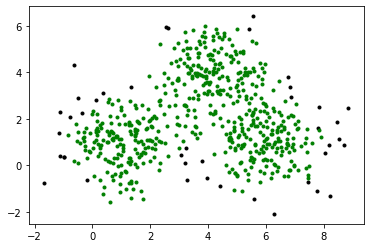

EPS = 0.6, Min-points = 15
Number of cluster: 2
Number of outliers: 97


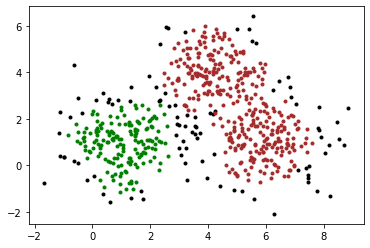

In [77]:
# Run program
# Set three centers, the model should predict similar results
center_1 = np.array([1,1])
center_2 = np.array([4,4])
center_3 = np.array([6,1])

# Generate random data and center it to the three centers
data_1 = np.random.randn(200,2) + center_1
data_2 = np.random.randn(200,2) + center_2
data_3 = np.random.randn(200,2) + center_3

train = np.concatenate((data_1, data_2, data_3), axis = 0)
# Set EPS and Min-point
epss = [0.4, 0.6]
minptss = [10, 15]
# Find ALl cluster, outliers in different setting and print resultsw
for eps in epss:
    for minpts in minptss:
        print('EPS = ' + str(eps) + ', Min-points = ' + str(minpts))
        pointlabel, cl = dbscan(train, eps, minpts)
        print('Number of cluster: ' + str(cl-1))
        counter = collections.Counter(pointlabel)
        outliers  = pointlabel.count(0)
        print('Number of outliers: ' + str(outliers))
        plotRes(train, pointlabel, cl)
        plt.show()
        

#### Sample Circle dataset

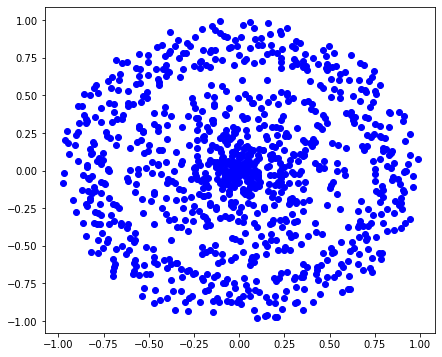

In [100]:
num_samples = 500

# make a simple unit circle 
theta = np.linspace(0, 2*np.pi, num_samples)
a, b = 1 * np.cos(theta), 1 * np.sin(theta)
r = np.random.uniform(0.0, 0.63, (num_samples, ))
x, y = r * np.cos(theta), r * np.sin(theta)
data1 = np.array([x, y]).T
a, b = 10 * np.cos(theta), 10 * np.sin(theta)
# r = np.random.rand(0.5, 1.0, (num_samples,))
r = np.random.uniform(0.7,1.0, (num_samples, ))
x, y = r * np.cos(theta), r * np.sin(theta)
data2 = np.array([x, y]).T

# plots
plt.figure(figsize=(7,6))
plt.plot(data1[:, 0], data1[:, 1], 'bo')
plt.plot(data2[:, 0], data2[:, 1], 'bo')
# plt.ylim([-1.5,1.5])
# plt.xlim([-1.5,1.5])
plt.show()

EPS = 0.1, Min-points = 9
Number of cluster: 3
Number of outliers: 62


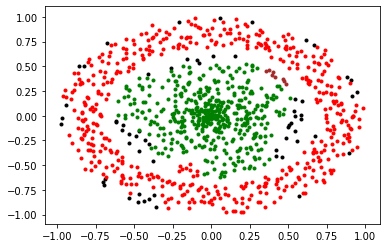

In [107]:
train = np.concatenate((data1, data2), axis = 0)
# Set EPS and Min-point
epss = [0.1]
minptss = [9]
# Find ALl cluster, outliers in different setting and print resultsw
for eps in epss:
    for minpts in minptss:
        print('EPS = ' + str(eps) + ', Min-points = ' + str(minpts))
        pointlabel, cl = dbscan(train, eps, minpts)
        print('Number of cluster: ' + str(cl-1))
        counter = collections.Counter(pointlabel)
        outliers  = pointlabel.count(0)
        print('Number of outliers: ' + str(outliers))
        plotRes(train, pointlabel, cl)
        plt.show()

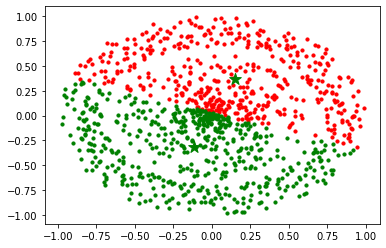

In [110]:
# Compare with K-Mean + Euclidean metric
centers_new, clusters, errors = KMeanClustering(train, k = 2, distance_metric = 'euclidean')
visualize(train, centers_new, clusters)